In [4]:
##direct import as similar to kaggle code
import kagglehub
read_only_path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")
print("Path to dataset files:", read_only_path)

Path to dataset files: /kaggle/input/wildfire-prediction-dataset


In [5]:
import os
import shutil

#source and destination paths
source_dir = read_only_path
writable_dir = "/content/wildfire_dataset_writable"

#Copying the entire directory tree to play with it on our own merit
print(f"\nCopying dataset from {source_dir} to {writable_dir}...")
if os.path.exists(writable_dir):
    shutil.rmtree(writable_dir) # Remove if it exists to ensure a fresh copy
shutil.copytree(source_dir, writable_dir)
print("Copying complete.")

train_dir = os.path.join(writable_dir, 'train')
valid_dir = os.path.join(writable_dir, 'valid')
test_dir = os.path.join(writable_dir, 'test')

#Verifying new paths to check if previous problems are not bothering me
print("\nUpdated paths to writable directories:")
print(f"Train directory: {train_dir} (Exists: {os.path.exists(train_dir)})")
print(f"Validation directory: {valid_dir} (Exists: {os.path.exists(valid_dir)})")
print(f"Test directory: {test_dir} (Exists: {os.path.exists(test_dir)})")


Copying dataset from /kaggle/input/wildfire-prediction-dataset to /content/wildfire_dataset_writable...
Copying complete.

Updated paths to writable directories:
Train directory: /content/wildfire_dataset_writable/train (Exists: True)
Validation directory: /content/wildfire_dataset_writable/valid (Exists: True)
Test directory: /content/wildfire_dataset_writable/test (Exists: True)


In [6]:
import tensorflow as tf

def find_and_remove_tf_unreadable_images(base_dir):
    corrupt_files = []
    total_files = 0
    print(f"Scanning directory: {base_dir}")
    for root, _, files in os.walk(base_dir):
        for file in files:
            total_files += 1
            file_path = os.path.join(root, file)
            try:
                raw_image = tf.io.read_file(file_path)
                tf.io.decode_jpeg(raw_image)
            except tf.errors.InvalidArgumentError as e:
                print(f"--> Found problematic file for TensorFlow: {file_path}")
                corrupt_files.append(file_path)
            except Exception as e:
                print(f"--> Found other problematic file: {file_path} - Error: {e}")
                corrupt_files.append(file_path)

    if corrupt_files:
        print(f"\nFound {len(corrupt_files)} problematic files. Removing them...")
        for file_path in corrupt_files:
            try:
                os.remove(file_path)
                print(f"Successfully removed: {file_path}")
            except OSError as e:
                print(f"Error removing file {file_path}: {e}")
        print("Removal complete.")
    else:
        print("No problematic files found by TensorFlow decoder.")
    print(f"\nScanned {total_files} files in total in {base_dir}.")

#cleaning process
print("\n--- Cleaning Writable Train Directory ---")
find_and_remove_tf_unreadable_images(train_dir)
print("\n--- Cleaning Writable Validation Directory ---")
find_and_remove_tf_unreadable_images(valid_dir)
print("\n--- Cleaning Writable Test Directory ---")
find_and_remove_tf_unreadable_images(test_dir)
print("\n\nDataset cleaning finished. Proceeding to load data...")


--- Cleaning Writable Train Directory ---
Scanning directory: /content/wildfire_dataset_writable/train
--> Found problematic file for TensorFlow: /content/wildfire_dataset_writable/train/nowildfire/-114.152378,51.027198.jpg

Found 1 problematic files. Removing them...
Successfully removed: /content/wildfire_dataset_writable/train/nowildfire/-114.152378,51.027198.jpg
Removal complete.

Scanned 30250 files in total in /content/wildfire_dataset_writable/train.

--- Cleaning Writable Validation Directory ---
Scanning directory: /content/wildfire_dataset_writable/valid
No problematic files found by TensorFlow decoder.

Scanned 6300 files in total in /content/wildfire_dataset_writable/valid.

--- Cleaning Writable Test Directory ---
Scanning directory: /content/wildfire_dataset_writable/test
--> Found problematic file for TensorFlow: /content/wildfire_dataset_writable/test/wildfire/-73.15884,46.38819.jpg

Found 1 problematic files. Removing them...
Successfully removed: /content/wildfire_da

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [8]:
#Constants to play around with
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = image_dataset_from_directory(
    valid_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

test_dataset = image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.
Found 6299 files belonging to 2 classes.
Class Names: ['nowildfire', 'wildfire']


In [9]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

In [10]:
custom_cnn = Sequential([
    Input(shape=IMG_SIZE + (3,)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="custom_cnn")

custom_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

print("\n--- Training Custom CNN ---")
history_cnn = custom_cnn.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset
)

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Custom CNN ---
Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 71s 68ms/step - accuracy: 0.8880 - loss: 0.2789 - val_accuracy: 0.9460 - val_loss: 0.1447
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 77s 67ms/step - accuracy: 0.9322 - loss: 0.1879 - val_accuracy: 0.9476 - val_loss: 0.1416
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.9398 - loss: 0.1632 - val_accuracy: 0.9478 - val_loss: 0.1489
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9427 - loss: 0.1559 - val_accuracy: 0.9570 - val_loss: 0.1210
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9465 - loss: 0.1459 - val_accuracy: 0.9554 - val_loss: 0.1447
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.9488 - loss: 0.1447 - val_accuracy: 0.9594 - val_loss: 0.1297
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9510 - loss: 0.1308 - val_accuracy: 0.9598 - val_loss: 0.1132
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accur

In [11]:
#Feature Extraction
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=IMG_SIZE + (3,))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs, outputs)

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Training Transfer Learning Model (Feature Extraction) ---")
history_transfer = transfer_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

#Part B: Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Training Transfer Learning Model (Fine-Tuning) ---")
history_fine_tune = transfer_model.fit(
    train_dataset,
    epochs=history_transfer.epoch[-1] + 10,
    initial_epoch=history_transfer.epoch[-1],
    validation_data=validation_dataset
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

--- Training Transfer Learning Model (Feature Extraction) ---
Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 84s 82ms/step - accuracy: 0.8909 - loss: 0.2589 - val_accuracy: 0.9498 - val_loss: 0.1393
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 76s 80ms/step - accuracy: 0.9382 - loss: 0.1689 - val_accuracy: 0.9497 - val_loss: 0.1366
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 72s 70ms/step - accuracy: 0.9379 - loss: 0.1634 - val_accuracy: 0.9414 - val_loss: 0.1586
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.9384 - loss: 0.1627 - val_accuracy: 0.9514 - val_loss: 0.1387
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.9402 - loss: 0.1599 - val_accuracy: 0.9522 - val_loss: 0.1293
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 93s 82ms/step - accuracy: 0.9408 - loss: 0.1604 - val_accuracy: 0.9538 - val_loss: 0.1235
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9407 - loss: 0.1610 - val_accuracy: 0.95

In [12]:
#this was just done because i am doing a research project regarding scoring methods and their fallacies,
#and Resnet's scores would be used to compare with other models, as part of one of the experiments including these
#Model 3: Transfer Learning with ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
print("\n\n--- Setting up ResNet50 Model ---")

#Feature Extraction
base_model_resnet = ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_resnet.trainable = False
inputs_resnet = Input(shape=IMG_SIZE + (3,))
x_resnet = data_augmentation(inputs_resnet)
x_resnet = tf.keras.applications.resnet.preprocess_input(x_resnet)
x_resnet = base_model_resnet(x_resnet, training=False)
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dropout(0.2)(x_resnet)
outputs_resnet = Dense(1, activation='sigmoid')(x_resnet)

resnet_model = Model(inputs_resnet, outputs_resnet, name="resnet50_transfer_model")

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()
print("\n--- Training ResNet50 Model (Feature Extraction) ---")
history_resnet = resnet_model.fit(
    train_dataset,
    epochs=10, # Keeping epochs consistent for comparison
    validation_data=validation_dataset,
    verbose=1
)

#Fine-Tuning
base_model_resnet.trainable = True
#fine-tuning a smaller portion of ResNet as it's a larger model, and i had some problems(blackout)
#unfreezing from the last convolutional block (e.g., from layer ~143 onwards).
for layer in base_model_resnet.layers[:143]:
    layer.trainable = False
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

print("\n--- Training ResNet50 Model (Fine-Tuning) ---")
history_fine_tune_resnet = resnet_model.fit(
    train_dataset,
    epochs=history_resnet.epoch[-1] + 10,
    initial_epoch=history_resnet.epoch[-1],
    validation_data=validation_dataset
)



--- Setting up ResNet50 Model ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50_transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      2,049 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training ResNet50 Model (Feature Extraction) ---
Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 180s 181ms/step - accuracy: 0.9224 - loss: 0.1991 - val_accuracy: 0.9524 - val_loss: 0.1259
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 182s 161ms/step - accuracy: 0.9509 - loss: 0.1310 - val_accuracy: 0.9537 - val_loss: 0.1310
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 152s 160ms/step - accuracy: 0.9536 - loss: 0.1214 - val_accuracy: 0.9590 - val_loss: 0.1157
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 168s 177ms/step - accuracy: 0.9565 - loss: 0.1152 - val_accuracy: 0.9525 - val_loss: 0.1341
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 202s 178ms/step - accuracy: 0.9584 - loss: 0.1123 - val_accuracy: 0.9551 - val_loss: 0.1233
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 168s 177ms/step - accuracy: 0.9583 - loss: 0.1163 - val_accuracy: 0.9613 - val_loss: 0.1098
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 168s 177ms/step - accuracy: 0.9583 - loss: 0.1122 - val_accuracy: 0.9611 - val_loss: 0.1095
Epoch 8/10
946/946 ━━━

In [13]:
#Getting true labels and predictions for alll three models
y_true = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
y_pred_cnn_prob = custom_cnn.predict(test_dataset).flatten()
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int)
y_pred_transfer_prob = transfer_model.predict(test_dataset).flatten()
y_pred_transfer = (y_pred_transfer_prob > 0.5).astype(int)
y_pred_resnet_prob = resnet_model.predict(test_dataset).flatten()
y_pred_resnet = (y_pred_resnet_prob > 0.5).astype(int)

print("\n--- Custom CNN Classification Report ---")
print(classification_report(y_true, y_pred_cnn, target_names=class_names))

print("\n--- Transfer Learning Model Classification Report ---")
print(classification_report(y_true, y_pred_transfer, target_names=class_names))

print("\n--- ResNet50 Model Classification Report ---")
print(classification_report(y_true, y_pred_resnet, target_names=class_names))

197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step

--- Custom CNN Classification Report ---
              precision    recall  f1-score   support

  nowildfire       0.98      0.96      0.97      2820
    wildfire       0.97      0.99      0.98      3479

    accuracy                           0.98      6299
   macro avg       0.98      0.97      0.98      6299
weighted avg       0.98      0.98      0.98      6299


--- Transfer Learning Model Classification Report ---
              precision    recall  f1-score   support

  nowildfire       0.92      0.99      0.95      2820
    wildfire       0.99      0.93      0.96      3479

    accuracy                           0.96      6299
   macro avg       0.96      0.96      0.96      6299
weighted avg       0.96      0.96      0.96      6299


--- ResNet50 Model Classification Report ---
              precision    recall  f1-score   support

  nowildfire      

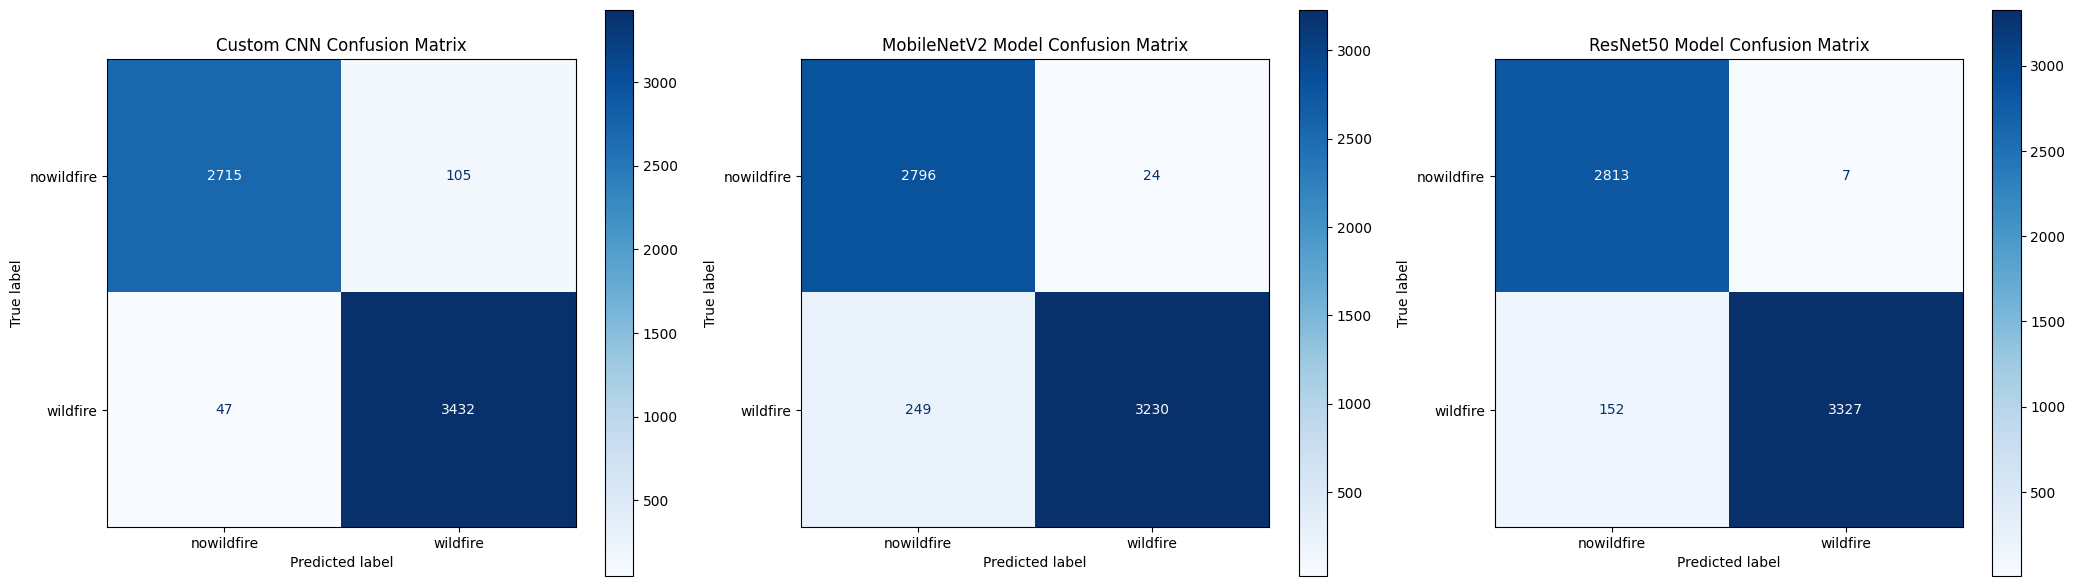

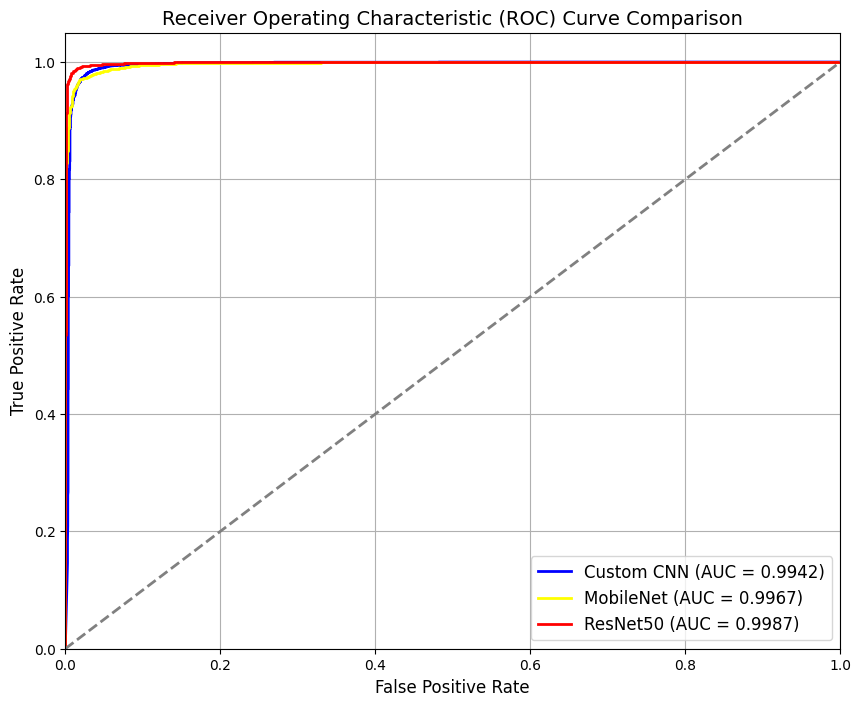

In [15]:
#Plots of Confusion Matrices(for each)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
#Custom CNN's plot
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_cnn, display_labels=class_names, ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Custom CNN Confusion Matrix')
#MobileNetV2's plot
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_transfer, display_labels=class_names, ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('MobileNetV2 Model Confusion Matrix')
#ResNet50's plot
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_resnet, display_labels=class_names, ax=axes[2], cmap=plt.cm.Blues)
axes[2].set_title('ResNet50 Model Confusion Matrix')
plt.tight_layout()
plt.show()

#ROC Curves
fpr_cnn, tpr_cnn, _ = roc_curve(y_true, y_pred_cnn_prob)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
fpr_transfer, tpr_transfer, _ = roc_curve(y_true, y_pred_transfer_prob)
roc_auc_transfer = auc(fpr_transfer, tpr_transfer)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true, y_pred_resnet_prob)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure(figsize=(10, 8))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'Custom CNN (AUC = {roc_auc_cnn:.4f})')
plt.plot(fpr_transfer, tpr_transfer, color='yellow', lw=2, label=f'MobileNet (AUC = {roc_auc_transfer:.4f})')
plt.plot(fpr_resnet, tpr_resnet, color='red', lw=2, label=f'ResNet50 (AUC = {roc_auc_resnet:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()